<a href="https://colab.research.google.com/github/KR-0822/PolarBear/blob/main/KNN_%EA%B2%A8%EC%9A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 전처리 및 데이터셋 생성

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import torch
 
# torch.cuda.is_available() 

In [ ]:
fn = pd.read_csv('/content/drive/MyDrive/해빙/data_v2/train_v2.csv')
fn.tail() # 데이터가 2019년까지임을 확인

,month,file_nm
489,2019-08,201908.npy
490,2019-09,201909.npy
491,2019-10,201910.npy
492,2019-11,201911.npy
493,2019-12,201912.npy


In [ ]:
# dm = fn.iloc[:, 1] # 1978년 - 2019년 데이터 불러오기
# dm

In [ ]:
DIR_TRAIN_PATH = '/content/drive/MyDrive/해빙/data_v2/train_data_v2/'
order = pd.read_csv('/content/drive/MyDrive/해빙/data_v2/train_v2.csv')
total_data = np.load(DIR_TRAIN_PATH + order['file_nm'][0])
total_data = total_data.reshape(1,448, 304, 5)

for i in tqdm(range(0, order.shape[0] - 1)):
    tmp = np.load(DIR_TRAIN_PATH + order['file_nm'][i + 1])
    tmp = tmp.reshape(1,448, 304, 5)

    total_data = np.concatenate((total_data, tmp), axis = 0)

total_data = np.array(total_data)
np.save('/content/drive/MyDrive/해빙/total_data.npy', total_data)

100%|██████████| 493/493 [03:01<00:00,  2.71it/s]


In [ ]:
 # total_data.shape 

In [ ]:
total_data = total_data[:, :, :, 0]
total_data.shape # (494, 448, 304)

(494, 448, 304)

In [ ]:
# 월별 데이터셋 만들기(매년 12월 데이터만 사용)
dec = 13 # fn['file_nm'][13] == '197912.npy'
total_data = total_data.reshape(494, 1, 448, 304)

winter = np.array(total_data[dec])


for i in tqdm(range(40)):
  winter = np.array(np.concatenate((winter, total_data[dec + 12 * (i + 1)])))

winter.shape

100%|██████████| 40/40 [00:00<00:00, 979.41it/s]


(41, 448, 304)

In [ ]:
np.save('/content/drive/MyDrive/해빙/winter.npy', winter)

In [ ]:
# 북극점 채우기(미리 했어야 하는걸...)
pole = np.load('/content/drive/MyDrive/해빙/total_data.npy')
pole = pole[:, :, :, 1]
np.save('/content/drive/MyDrive/해빙/pole.npy', pole)

In [ ]:
# pole.shape (495, 448, 304)

In [ ]:
pole = pole.reshape(494, 1, 448, 304)
pole_winter = np.array(pole[dec])

for i in tqdm(range(40)):
  pole_winter = np.array(np.concatenate((pole_winter, pole[dec + 12 * (i + 1)])))

pole_winter.shape # (41, 448, 304)

100%|██████████| 40/40 [00:00<00:00, 1225.66it/s]


(41, 448, 304)

In [ ]:
winter_plus_pole = winter + pole_winter * 250

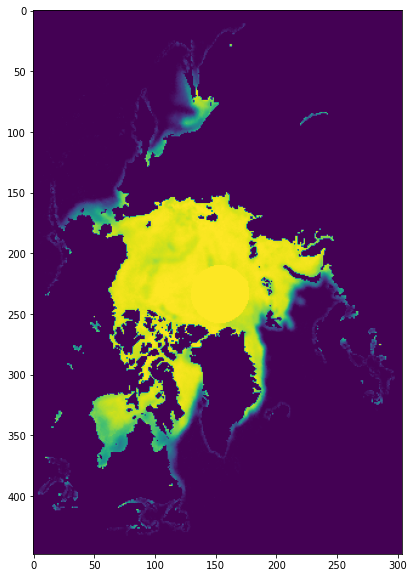

In [ ]:
# 북극점 채워진 모습 확인
plt.figure(figsize =  (10, 10))  
plt.imshow(winter_plus_pole[0, :, :])
np.save('/content/drive/MyDrive/해빙/winter_plus_pole', winter_plus_pole) # 최종 학습데이터(1979 - 2019년 12월 & 북극점 포함)

In [ ]:
winter_plus_pole_sum = winter_plus_pole.sum(axis = 1)
winter_plus_pole_sum = winter_plus_pole_sum.sum(axis = 1)
pd.DataFrame(winter_plus_pole_sum)

,0
0,4732161
1,4788017
2,4679094
3,4841986
4,4721890
5,4595717
6,4579351
7,4694768
8,4460399
9,4923944


# 북극점을 채운, 시간에 따른 겨울 빙하 농도 변화 그래프

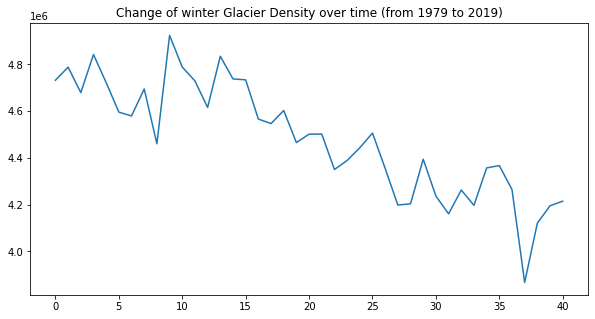

In [ ]:
plt.figure(figsize = (10,5))
plt.title('Change of winter Glacier Density over time (from 1979 to 2019)')

plt.plot(winter_plus_pole_sum)
plt.show()

# 북극점을 채우지 않았을 때와 비교한 그래프

- 1979-1988년의 농도 보정

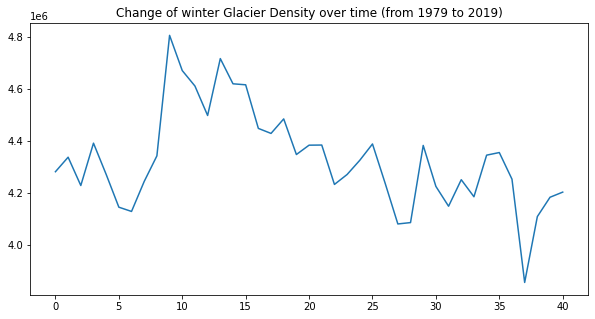

In [ ]:
winter_sum = winter.sum(axis = 1)
winter_sum = winter_sum.sum(axis = 1)

plt.figure(figsize = (10,5))
plt.title('Change of winter Glacier Density over time (from 1979 to 2019)')

plt.plot(winter_sum)
plt.show()

# 여름일 때와 비교한 그래프

- 겨울보다 여름에 감소한 폭이 더 크다

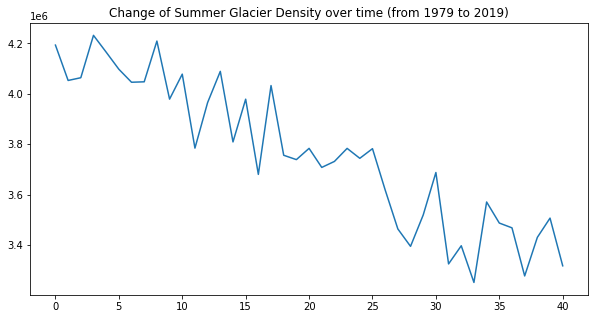

In [ ]:
summer_plus_pole = np.load('/content/drive/MyDrive/해빙/summer_plus_pole.npy')
summer_sum = summer_plus_pole.sum(axis = 1)
summer_sum = summer_sum.sum(axis = 1)

plt.figure(figsize = (10, 5))
plt.title('Change of Summer Glacier Density over time (from 1979 to 2019)')

plt.plot(summer_sum)
plt.show()

# 훈련 및 평가

In [ ]:
# 여기부터 다시 시작
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor

from google.colab import drive
drive.mount('/content/drive')

winter_plus_pole = np.load('/content/drive/MyDrive/해빙/winter_plus_pole.npy')

Mounted at /content/drive


In [ ]:
def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)<250*0.5)
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

def fun1(x) : 
  return np.around(x,2)

In [ ]:
x_train = winter_plus_pole[0:39].reshape(39, -1).T
y_train = winter_plus_pole[39].reshape(1, -1).T
x_test = winter_plus_pole[1:40].reshape(39, -1).T
y_test = winter_plus_pole[40].reshape(1, -1).T

from sklearn.neighbors import KNeighborsRegressor

num = [100, 150, 200, 225, 250, 275, 300, 325, 350, 375, 400, 450, 500, 550, 600, 650, 700, 750] #400 - 450 사이가 fscore가 제일 좋았음.

for k in tqdm(num):
  print()
  print('num: {}'.format(k))
  model = KNeighborsRegressor(n_neighbors = k, weights = 'distance', p = 2, n_jobs = -1)
  model.fit(x_train, y_train)

  tmp = model.predict(x_test)
  tmp = tmp.reshape(-1)

  print( "MAE : %s" % mae_score(y_test.reshape(-1), fun1(tmp)),
        '\n F1 : %s' % f1_score(y_test.reshape(-1), fun1(tmp)),
        '\n Final %s' % mae_over_f1(y_test.reshape(-1), fun1(tmp)))
  print()

In [ ]:
x_train = winter_plus_pole[0:39].reshape(39, -1).T
y_train = winter_plus_pole[39].reshape(1, -1).T
x_test = winter_plus_pole[1:40].reshape(39, -1).T
y_test = winter_plus_pole[40].reshape(1, -1).T

from sklearn.neighbors import KNeighborsRegressor

num = [400, 402, 404, 406, 408, 410, 412, 414, 46, 418, 420, 422, 424, 426, 428, 430, 434, 436, 438, 440, 442, 444, 446, 448, 450] 

for k in tqdm(num):
  print()
  print('num: {}'.format(k))
  model = KNeighborsRegressor(n_neighbors = k, weights = 'distance', p = 2, n_jobs = -1)
  model.fit(x_train, y_train)

  tmp = model.predict(x_test)
  tmp = tmp.reshape(-1)

  print( "MAE : %s" % mae_score(y_test.reshape(-1), fun1(tmp)),
        '\n F1 : %s' % f1_score(y_test.reshape(-1), fun1(tmp)),
        '\n Final %s' % mae_over_f1(y_test.reshape(-1), fun1(tmp)))
  print()

  0%|          | 0/25 [00:00<?, ?it/s]


num: 400


  4%|▍         | 1/25 [08:08<3:15:12, 488.02s/it]

MAE : 3.0730722803101505 
 F1 : 0.9718178600000887 
 Final 3.1621895163441165


num: 402


  8%|▊         | 2/25 [16:08<3:05:27, 483.81s/it]

MAE : 3.0731382166353383 
 F1 : 0.9718422053530271 
 Final 3.162178147940408


num: 404


 12%|█▏        | 3/25 [24:13<2:57:27, 483.98s/it]

MAE : 3.0731324894266923 
 F1 : 0.9718422053530271 
 Final 3.1621722547938087


num: 406


 16%|█▌        | 4/25 [32:17<2:49:28, 484.20s/it]

MAE : 3.073086671757519 
 F1 : 0.9718393835072778 
 Final 3.16213429120941


num: 408


 20%|██        | 5/25 [40:21<2:41:23, 484.16s/it]

MAE : 3.0730287388392856 
 F1 : 0.971815035785316 
 Final 3.1621539017807603


num: 410


 24%|██▍       | 6/25 [48:24<2:33:07, 483.56s/it]

MAE : 3.0730603853383456 
 F1 : 0.971840794500847 
 Final 3.1621026521074285


num: 412


 28%|██▊       | 7/25 [56:28<2:25:08, 483.82s/it]

MAE : 3.073011924342105 
 F1 : 0.9718651422581587 
 Final 3.1619735692774524


num: 414


 32%|███▏      | 8/25 [1:04:30<2:16:57, 483.40s/it]

MAE : 3.0730531161889094 
 F1 : 0.9718908997183919 
 Final 3.1619321525286566


num: 46


 36%|███▌      | 9/25 [1:12:31<2:08:39, 482.49s/it]

MAE : 3.1520688439849627 
 F1 : 0.9727417512875994 
 Final 3.2403963409699097


num: 418


 40%|████      | 10/25 [1:20:35<2:00:43, 482.93s/it]

MAE : 3.0731209615836463 
 F1 : 0.971892308060165 
 Final 3.1619973781842408


num: 420


 44%|████▍     | 11/25 [1:28:41<1:52:53, 483.83s/it]

MAE : 3.0732208940319548 
 F1 : 0.9717921026458893 
 Final 3.162426257674108


num: 422


 48%|████▊     | 12/25 [1:36:44<1:44:47, 483.68s/it]

MAE : 3.073328829887218 
 F1 : 0.9718908997183919 
 Final 3.1622158404359637


num: 424


 52%|█████▏    | 13/25 [1:44:47<1:36:42, 483.57s/it]

MAE : 3.0732826450892863 
 F1 : 0.9718422053530271 
 Final 3.162326761009141


num: 426


In [ ]:
# num: 414
#  32%|███▏      | 8/25 [1:04:30<2:16:57, 483.40s/it]MAE : 3.0730531161889094 
#  F1 : 0.9718908997183919 
#  Final 3.1619321525286566

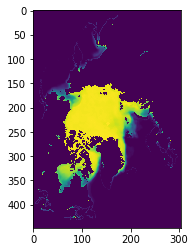

In [ ]:
#2020년 12월 예측

x_train = winter_plus_pole[0:39].reshape(39, -1).T
y_train = winter_plus_pole[39].reshape(1, -1).T
x_test = winter_plus_pole[1:40].reshape(39, -1).T

model = KNeighborsRegressor(n_neighbors = 414, weights = 'distance', p = 2, n_jobs = -1)
model.fit(x_train, y_train)

predictions = model.predict(x_test)
predictions = predictions.reshape(-1)

plt.imshow(predictions.reshape(448, 304), interpolation = 'None')
plt.show()

In [ ]:
predictions = predictions.reshape(448, 304)
df = pd.DataFrame(predictions)
df.to_csv('/content/drive/MyDrive/해빙/prediction_winter.csv', index = False)

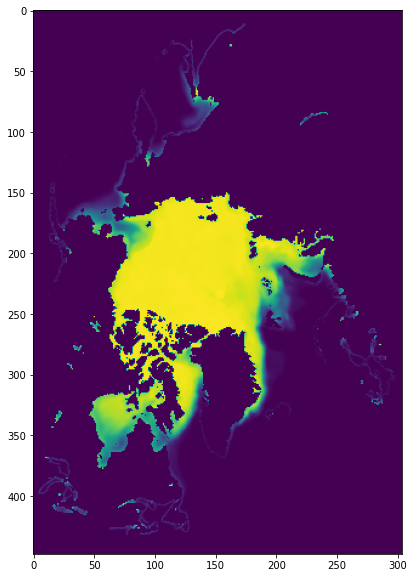

In [ ]:
plt.figure(figsize = (20, 10)) # 더 큰 그림으로 보기
plt.imshow(predictions)
plt.show()

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir {DIR_NAME}